In [0]:
import torch
import torchvision
import os

# from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 22})

In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x5c798000 @  0x7fdcde2241c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
0.4.0
True


In [0]:
!pip3 install torchvision

In [0]:
batch_size = 100
dataset_size = 55000
validation_size = 5000
test_size = 10000

In [0]:
def random_split(dataset, lengths):
    """
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    Arguments:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths of splits to be produced
    """
    if sum(lengths) != len(dataset):
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = torch.randperm(sum(lengths))
    return [Subset(dataset, indices[offset - length:offset]) for offset, length in zip(_accumulate(lengths), lengths)]

In [5]:
np.random.seed(42)
torch.manual_seed(42)

# Load MNIST training set
train_data = torchvision.datasets.MNIST(root=os.environ.get("DATASETS_PATH", "~/datasets"), train=True,
                                         download=True, transform=transforms.ToTensor())

# Split training set into training and validation set
train_data, validation_data = random_split(train_data,[dataset_size, validation_size])
# Load MNIST test set
test_data = torchvision.datasets.MNIST(root=os.environ.get("DATASETS_PATH", "~/datasets"), train=False,
                                        download=True, transform=transforms.ToTensor())

# Put datasets into data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=0)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=validation_size, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_size, num_workers=0)

Processing...
Done!


In [0]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(784, 400, bias=True),
                      nn.SELU(),
                      nn.Linear(400, 400, bias=True),
                      nn.SELU(),
                      nn.Linear(400, 400, bias=True),
                      nn.SELU(),
                      nn.Linear(400,10, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [9]:
torch.cuda.is_available()

True

In [0]:
class evaluation(object):
    def __init__(self, test_data, criterion):
        self.test_data = test_data
        self.criterion = criterion
        self.n = 0
        self.avg_prediction = 0.

    def acc(self, model):

        with torch.autograd.no_grad():
            self.n += 1
            for x, y in iter(self.test_data):
                x = x.view(x.size(0), -1)
                x = x.to(device)
                y = y.to(device)
                predictions = model(x)
                self.avg_prediction = self.avg_prediction * (self.n - 1.) / self.n + predictions / self.n

                loss = self.criterion(self.avg_prediction, y)
                acc = 100 * (self.avg_prediction.argmax(1) == y).float().sum() / x.shape[0]

        return loss, acc

In [0]:
from enum import Enum
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


class sgld(object):

    def __init__(self, network, lr, lambda_, batch_size, dataset_size):
        self.network = network
        self.n = batch_size
        self.N = dataset_size
        self.linear_layers = [m for m in self.network.modules() if isinstance (m, nn.Linear)]
        self.lr_init = lr
        self.lambda_ = lambda_
        self.t = 1.





    def step(self,):
        learning_rate = self.lr_init * 0.5 ** (self.t // 10000)
        for l in self.linear_layers:
            likelihood_grad = l.weight.grad
            prior_grad = l.weight.data
            if l.bias is not None:
                bias_grad = l.bias.grad
                likelihood_grad = torch.cat((likelihood_grad, bias_grad.unsqueeze(1)), 1)
                prior_grad = torch.cat((prior_grad, l.bias.data.unsqueeze(1)), 1)

            likelihood_grad *= float(self.N) / self.n


            posterior_grad = likelihood_grad.add(self.lambda_, prior_grad)
            noise = torch.randn_like(posterior_grad) * math.sqrt(learning_rate)
            update = (learning_rate * posterior_grad).add_(noise)

            if l.bias is not None:
                l.weight.data.add_(-update[:, :-1])
                l.bias.data.add_(-update[:, -1])
            else:
                l.weight.data.add_(-update)
        self.t +=1

In [11]:


np.random.seed(42)
torch.manual_seed(42)


# Model parameter
lambda_ = 1.
#lr = 3e-6

#learning_rates = [1e-6, 1e-7, 1e-8]
#learning_rates = [3e-6, 2e-6, 1e-6, 9e-7, 8e-7, 7e-7, 6e-7, 5e-7]
#learning_rates = [3e-6]
learning_rates = [2e-6]

t = 1
n = 0

#error_results = []
losses_sgld = []
acc_sgld = []
for lr in learning_rates:
    network = Model()
    criterion = nn.CrossEntropyLoss(size_average=False)
    optim = sgld(network, lr, lambda_, batch_size, dataset_size)
    evaluate = evaluation(test_loader, criterion)
    for epoch in range(25):
        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)
            x = x.to(device)
            y = y.to(device)

            network.zero_grad()
            output = network(x)
            loss = criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size
            prediction = output.data.max(1)[1]
            accuracy = torch.sum(prediction.eq(y)).float()/batch_size


            if (t >= 300) & (t % 100 == 0):
                loss, acc = evaluate.acc(network)
                losses_sgld.append(loss)
                acc_sgld.append(acc)


            t += 1.



        print("Epoch {:d} - loss: {:.4f} - acc: {:.4f}".format(epoch, running_loss, accuracy))

    #error_sgld = 100. - acc
    #print(error_sgld)
    #error_results.append(error_sgld)

Epoch 0 - loss: 42.5379 - acc: 0.9100
Epoch 1 - loss: 26.8964 - acc: 0.9400
Epoch 2 - loss: 18.7595 - acc: 0.9500
Epoch 3 - loss: 14.6478 - acc: 0.9500
Epoch 4 - loss: 12.7381 - acc: 0.9600
Epoch 5 - loss: 11.1794 - acc: 0.9600
Epoch 6 - loss: 10.0574 - acc: 0.9500
Epoch 7 - loss: 9.2856 - acc: 0.9700
Epoch 8 - loss: 8.9695 - acc: 0.9900
Epoch 9 - loss: 9.0629 - acc: 0.9800
Epoch 10 - loss: 8.6770 - acc: 0.9700
Epoch 11 - loss: 8.8417 - acc: 0.9500
Epoch 12 - loss: 8.3022 - acc: 0.9800
Epoch 13 - loss: 8.7621 - acc: 0.9700
Epoch 14 - loss: 7.9398 - acc: 0.9700
Epoch 15 - loss: 9.4037 - acc: 0.9900
Epoch 16 - loss: 8.7894 - acc: 0.9800
Epoch 17 - loss: 9.2472 - acc: 0.9800
Epoch 18 - loss: 4.7222 - acc: 0.9900
Epoch 19 - loss: 2.1387 - acc: 1.0000
Epoch 20 - loss: 2.0349 - acc: 0.9900
Epoch 21 - loss: 2.3188 - acc: 1.0000
Epoch 22 - loss: 2.2252 - acc: 1.0000
Epoch 23 - loss: 2.3344 - acc: 1.0000
Epoch 24 - loss: 2.7830 - acc: 0.9900


In [0]:
np.save("mnist_accSGLD.npy",acc_sgld)
np.save("mnist_lossSGLD.npy",losses_sgld)

In [25]:
import os
print( os.getcwd() )
print( os.listdir() )

/content
['.config', 'sample_data', 'mnist_accKSGFS.npy', 'mnist_lossKSGFS.npy', 'mnist_accpKSGFS.npy']


In [0]:
from google.colab import files
files.download( "mnist_accSGLD.npy" )  
files.download( "mnist_lossSGLD.npy" )  

In [10]:
error_results
# 2e-6

[tensor(1.8200, device='cuda:0')]

In [24]:
acc_sgld = np.load('mnist_accSGLD.npy')
loss_sgld = np.load('mnist_lossSGLD.npy')
acc_psgld = np.load('mnist_accpSGLD.npy')
loss_psgld = np.load('mnist_losspSGLD.npy')

acc_ksgfs = np.load('mnist_accpKSGFS.npy')
loss_ksgfs = np.load('mnist_lossKSGFS.npy')

FileNotFoundError: ignored

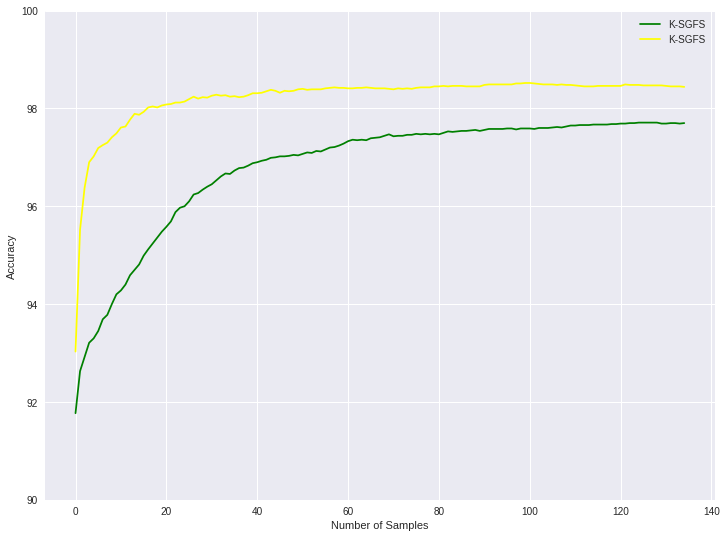

In [38]:
plt.figure(figsize=(12,9))
#plt.plot(range(len(acc_sgld)),acc_sgld, label="SGLD")
#plt.plot(range(len(acc_psgld)),acc_psgld, label="pSGLD", color='red')
plt.plot(range(len(acc_ksgfs)),acc_ksgfs, label="K-SGFS", color='green')
plt.plot(range(len(acc_ksgld)),acc_ksgld, label="K-SGFS", color='yellow')
plt.plot
plt.ylim(90,100)
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')
plt.legend()

In [0]:
from enum import Enum
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


class psgld(object):
    ### pSGLD with RMSProp as preconditioner

    def __init__(self, network, lr, alpha, lambda_, batch_size, dataset_size):
        self.network = network
        self.n = batch_size
        self.N = dataset_size
        self.linear_layers = [m for m in self.network.modules() if isinstance (m, nn.Linear)]
        self.lr_init = lr
        self.alpha = alpha
        self.lambda_ = lambda_
        self.t = 1.

        self.square_avg = dict()

    def step(self,):
        learning_rate = self.lr_init * 0.5 ** (self.t // 10000)
        for l in self.linear_layers:
            likelihood_grad = l.weight.grad
            prior_grad = l.weight.data
            if l.bias is not None:
                likelihood_grad = torch.cat((likelihood_grad, l.bias.grad.unsqueeze(1)), 1)
                prior_grad = torch.cat((prior_grad, l.bias.data.unsqueeze(1)), 1)

            likelihood_grad *= float(self.N) / self.n

            posterior_grad = likelihood_grad.add(self.lambda_, prior_grad)

            if self.t == 1:
                self.square_avg[l] = torch.zeros_like(posterior_grad)

            self.square_avg[l].mul_(self.alpha).addcmul_(1. - self.alpha, likelihood_grad, likelihood_grad)
            avg = self.square_avg[l].sqrt().add_(1e-4)
            noise = torch.randn_like(posterior_grad)


            update = (learning_rate * 0.5 * torch.div(posterior_grad, avg)).addcdiv_(math.sqrt(learning_rate), noise, avg.sqrt())


            if l.bias is not None:
                l.weight.data.add_(-1, update[:, :-1])
                l.bias.data.add_(-1, update[:, -1])
            else:
                l.weight.data.add_(-1, update)

        self.t +=1

In [11]:


np.random.seed(42)
torch.manual_seed(42)


# Model parameter
lambda_ = 1.
#lr = 3e-6

#learning_rates = [4e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
#learning_rates = [4e-3, 3e-3, 2e-3, 1e-3, 9e-3, 8e-3, 7e-3, 6e-5, 5e-5]
learning_rates = [4e-4]
alpha = 0.99


t = 1.
n = 0.

error_psgld = []
losses_psgld = []
acc_psgld = []
for lr in learning_rates:
    network = Model()
    criterion = nn.CrossEntropyLoss(size_average=False)
    optim = psgld(network, lr, alpha, lambda_, batch_size, dataset_size)
    evaluate = evaluation(test_loader, criterion)
    for epoch in range(25):
        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)
            x = x.to(device)
            y = y.to(device)

            network.zero_grad()
            output = network(x)
            loss = criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size
            prediction = output.data.max(1)[1]
            accuracy = torch.sum(prediction.eq(y)).float()/batch_size


            if (t >= 300) & (t % 100 == 0):
                loss, acc = evaluate.acc(network)
                losses_psgld.append(loss)
                acc_psgld.append(acc)


            t += 1.

    #     losses_psgld.append(loss)
    #     acc_psgld.append(acc)

        print("Epoch {:d} - loss: {:.4f} - acc: {:.4f}".format(epoch, running_loss, accuracy))

    error = 100. - acc
    print(error)
    error_psgld.append(error)

Epoch 0 - loss: 38.0347 - acc: 0.9300
Epoch 1 - loss: 25.0518 - acc: 0.9500
Epoch 2 - loss: 19.3185 - acc: 0.9500
Epoch 3 - loss: 15.5969 - acc: 0.9600
Epoch 4 - loss: 13.5469 - acc: 0.9600
Epoch 5 - loss: 12.2951 - acc: 0.9600
Epoch 6 - loss: 11.0892 - acc: 0.9600
Epoch 7 - loss: 10.5837 - acc: 0.9500
Epoch 8 - loss: 9.8929 - acc: 0.9500
Epoch 9 - loss: 9.3612 - acc: 0.9800
Epoch 10 - loss: 8.7391 - acc: 0.9900
Epoch 11 - loss: 8.1907 - acc: 0.9900
Epoch 12 - loss: 8.0519 - acc: 0.9600
Epoch 13 - loss: 7.7994 - acc: 0.9500
Epoch 14 - loss: 7.3934 - acc: 1.0000
Epoch 15 - loss: 7.5682 - acc: 0.9700
Epoch 16 - loss: 6.7709 - acc: 0.9800
Epoch 17 - loss: 7.1237 - acc: 0.9600
Epoch 18 - loss: 5.0832 - acc: 0.9900
Epoch 19 - loss: 4.0295 - acc: 1.0000
Epoch 20 - loss: 4.1521 - acc: 0.9700
Epoch 21 - loss: 4.2246 - acc: 0.9900
Epoch 22 - loss: 3.8858 - acc: 0.9800
Epoch 23 - loss: 4.1154 - acc: 0.9800
Epoch 24 - loss: 4.0699 - acc: 0.9900
tensor(2.6700, device='cuda:0')


In [0]:
np.save("mnist_accpSGLD.npy",acc_psgld)
np.save("mnist_losspSGLD.npy",losses_psgld)

In [0]:
from google.colab import files
files.download( "mnist_accpSGLD.npy" )  
files.download( "mnist_losspSGLD.npy" ) 

In [12]:
acc_psgld

[tensor(90.6800, device='cuda:0'),
 tensor(91.8600, device='cuda:0'),
 tensor(92.2700, device='cuda:0'),
 tensor(92.6900, device='cuda:0'),
 tensor(92.8500, device='cuda:0'),
 tensor(92.9800, device='cuda:0'),
 tensor(93.2400, device='cuda:0'),
 tensor(93.4400, device='cuda:0'),
 tensor(93.7000, device='cuda:0'),
 tensor(93.9300, device='cuda:0'),
 tensor(94.1000, device='cuda:0'),
 tensor(94.1900, device='cuda:0'),
 tensor(94.4100, device='cuda:0'),
 tensor(94.5300, device='cuda:0'),
 tensor(94.6500, device='cuda:0'),
 tensor(94.6800, device='cuda:0'),
 tensor(94.7800, device='cuda:0'),
 tensor(94.9200, device='cuda:0'),
 tensor(95.0500, device='cuda:0'),
 tensor(95.1700, device='cuda:0'),
 tensor(95.2700, device='cuda:0'),
 tensor(95.4300, device='cuda:0'),
 tensor(95.5200, device='cuda:0'),
 tensor(95.5500, device='cuda:0'),
 tensor(95.6200, device='cuda:0'),
 tensor(95.7200, device='cuda:0'),
 tensor(95.8600, device='cuda:0'),
 tensor(95.9100, device='cuda:0'),
 tensor(95.9100, dev

In [0]:
from enum import Enum

import scipy.linalg as la

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math


class BackpropMode(Enum):
    STANDARD = 0
    CURVATURE = 1


class KSGLD(object):

    def __init__(self, net, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1e-3, epsilon=1e-3, l2=1e-3, invert_every=1):
        if not isinstance(criterion, (nn.CrossEntropyLoss, nn.BCEWithLogitsLoss, nn.MSELoss)):
            raise ValueError("Unrecognized loss:", criterion.__class__.__name__)


        self.net = net
        self.criterion = criterion
        self.invert_every = invert_every
        self.inversion_counter = -1


        self.n = batch_size
        self.N = dataset_size
        self.epsilon= epsilon


        self.eta = eta
        self.v = v
        self.lambda_ = lambda_
        self.l2 = l2

        self.mode = BackpropMode.STANDARD

        self.linear_layers = [m for m in self.net.modules() if isinstance(m, nn.Linear)]

        self.input_covariances = dict()
        self.preactivation_fishers = dict()
        self.preactivations = dict()
        self.preactivation_fisher_inverses = dict()
        self.input_covariance_inverses = dict()

        self.t = 1.

        self._add_hooks_to_net()

    def update_curvature(self, x):
        self.mode = BackpropMode.CURVATURE

        output = self.net(x)
        preacts = [self.preactivations[l] for l in self.linear_layers]
        if isinstance(self.criterion, nn.CrossEntropyLoss):
            p = F.softmax(output, 1).detach()
            label_sample = torch.multinomial(p, 1, out=p.new(p.size(0)).long()).squeeze()
            loss_fun = F.cross_entropy
        elif isinstance(self.criterion, nn.MSELoss):
            p = output.detach()
            label_sample = torch.normal(p, 1.)
            loss_fun = lambda x, y, **kwargs: 0.5 * F.mse_loss(x, y, **kwargs).sum(1)
        elif isinstance(self.criterion, nn.BCEWithLogitsLoss):
            p = output.detach()
            p = F.sigmoid(p)
            label_sample = torch.bernoulli(p)
            loss_fun = lambda x, y, **kwargs: F.binary_cross_entropy_with_logits(x, y, **kwargs).sum(1)
        else:
            raise NotImplemented

        l = sum(loss_fun(output, label_sample, reduce=False))
        preact_grads = torch.autograd.grad(l, preacts)
        scale = p.size(0) ** -1
        for pg, mod in zip(preact_grads, self.linear_layers):
            preact_fisher = pg.t().mm(pg).detach() * scale
            self._update_factor(self.preactivation_fishers, mod, preact_fisher)

        self.mode = BackpropMode.STANDARD

        self.inversion_counter += 1
        if self.inversion_counter % self.invert_every == 0:
            self.inversion_counter = 0
            self.invert_curvature()

    def invert_curvature(self):
        self._invert_fn(self.preactivation_fishers, self.preactivation_fisher_inverses)
        self._invert_fn(self.input_covariances, self.input_covariance_inverses)

    def _invert_fn(self, d, inv_dict):
        for mod, mat in d.items():
            l, u = map(mat.new, la.eigh(mat.cpu().numpy()))

            
            inv = (u * ((l + self.lambda_) ** -1)).mm(u.t())
            inv_dict[mod] = inv

    def _linear_forward_hook(self, mod, inputs, output):
        if self.mode == BackpropMode.CURVATURE:
            self.preactivations[mod] = output
            inp = inputs[0]
            scale = output.size(0) ** -1
            if mod.bias is not None:
                inp = torch.cat((inp, inp.new(inp.size(0), 1).fill_(1)), 1)
            input_cov = inp.t().mm(inp).detach() * scale
            self._update_factor(self.input_covariances, mod, input_cov)

    def _update_factor(self, d, mod, mat):
        if mod not in d or (self.v == 0 and self.eta == 1):
            d[mod] = mat
        else:
            d[mod] = self.v * d[mod] + self.eta * mat

    def step(self, closure=None):
        for l in self.linear_layers:
            likelihood_grad = l.weight.grad
            prior_grad = l.weight.data
            if l.bias is not None:
                bias_grad = l.bias.grad
                likelihood_grad = torch.cat((likelihood_grad, bias_grad.unsqueeze(1)), 1)
                prior_grad = torch.cat((l.weight.data, l.bias.data.unsqueeze(1)), 1)

            likelihood_grad *= float(self.N) / self.n

            posterior_grad = likelihood_grad.add(self.lambda_, prior_grad)

            noise = torch.randn_like(posterior_grad)

            A_inv = self.input_covariance_inverses[l]
            G_inv = self.preactivation_fisher_inverses[l]

            nat_grad = G_inv.mm(posterior_grad).mm(A_inv)

            A_inv_ch = torch.potrf(A_inv)
            G_inv_ch = torch.potrf(G_inv, upper=False)

            noise_precon = G_inv_ch.mm(noise).mm(A_inv_ch)

            eps = self.epsilon * 0.5 ** (self.t // 10000) 
            learning_rate = eps * 0.5 * float(self.N) / self.n
            noise_factor = math.sqrt(eps * float(self.n) / self.N)

            update = (learning_rate *  nat_grad).add(noise_factor, noise_precon)

            if l.bias is not None:
                l.weight.data.add_(-1, update[:, :-1])
                l.bias.data.add_(-1, update[:, -1])
            else:
                l.weight.data.add_(-1, update)
        self.t += 1

    def _add_hooks_to_net(self):
        def register_hook(m):
            if isinstance(m, nn.Linear):
                m.register_forward_hook(self._linear_forward_hook)

        self.net.apply(register_hook)

In [36]:


np.random.seed(42)
torch.manual_seed(42)


# Model parameter

#lr = 3e-6

#learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
#learning_rates = [5e-2, 4e-2, 3e-2, 2e-2, 1e-2, 9e-3, 8e-3, 7e-3, 6e-3, 5e-3]
learning_rates = [4e-7]

eta = 1.
v = 0
lambda_ = 1.
l2 = 1e-3


t = 1
n = 0

error_ksgld = []
losses_ksgld = []
acc_ksgld = []
for lr in learning_rates:
    network = Model()
    criterion = nn.CrossEntropyLoss(size_average=False)
    optim = KSGLD(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    evaluate = evaluation(test_loader, criterion)
    for epoch in range(25):
        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)
            x = x.to(device)
            y = y.to(device)
            
            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size
            prediction = output.data.max(1)[1]
            accuracy = torch.sum(prediction.eq(y)).float()/batch_size


            if (t >= 300) & (t % 100 == 0):
                with torch.autograd.no_grad():
                    for x,y in iter(test_loader):
                        loss, acc = evaluate.acc(network)
                        losses_ksgld.append(loss)
                        acc_ksgld.append(acc)
                        

            t += 1.

    #     losses_psgld.append(loss)
    #     acc_psgld.append(acc)

        print("Epoch {:d} - loss: {:.4f} - acc: {:.4f}".format(epoch, running_loss, accuracy))

    error = 100. - acc
    print(error)
    error_ksgld.append(error)

Epoch 0 - loss: 131.3690 - acc: 0.9500
Epoch 1 - loss: 22.0295 - acc: 0.9600
Epoch 2 - loss: 17.4569 - acc: 0.9700
Epoch 3 - loss: 14.8613 - acc: 0.9700
Epoch 4 - loss: 10.1928 - acc: 0.9700
Epoch 5 - loss: 7.5079 - acc: 0.9900
Epoch 6 - loss: 7.8191 - acc: 0.9900
Epoch 7 - loss: 8.3293 - acc: 0.9800
Epoch 8 - loss: 6.9378 - acc: 0.9800
Epoch 9 - loss: 7.4143 - acc: 0.9900
Epoch 10 - loss: 4.4740 - acc: 1.0000
Epoch 11 - loss: 4.1582 - acc: 0.9800
Epoch 12 - loss: 5.3106 - acc: 1.0000
Epoch 13 - loss: 4.9817 - acc: 0.9800
Epoch 14 - loss: 3.0719 - acc: 0.9900
Epoch 15 - loss: 3.2727 - acc: 0.9900
Epoch 16 - loss: 3.4595 - acc: 0.9900
Epoch 17 - loss: 3.4793 - acc: 0.9900
Epoch 18 - loss: 1.3609 - acc: 1.0000
Epoch 19 - loss: 0.2384 - acc: 1.0000
Epoch 20 - loss: 0.0500 - acc: 1.0000
Epoch 21 - loss: 0.0322 - acc: 1.0000
Epoch 22 - loss: 0.0335 - acc: 1.0000
Epoch 23 - loss: 0.0363 - acc: 1.0000
Epoch 24 - loss: 0.0396 - acc: 1.0000
tensor(1.5600, device='cuda:0')


In [41]:
len(acc_ksgld)

135

In [0]:
np.save("mnist_accKSGLD.npy",acc_ksgld)
np.save("mnist_lossKSGLD.npy",losses_ksgld)

In [0]:
from google.colab import files
files.download( "mnist_accKSGLD.npy" )  
files.download( "mnist_lossKSGLD.npy" )

In [0]:
from enum import Enum

import scipy.linalg as la

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math


class BackpropMode(Enum):
    STANDARD = 0
    CURVATURE = 1


class KSGFS(object):

    def __init__(self, net, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1e-3, epsilon=1e-3, l2=1e-3, invert_every=1):
        if not isinstance(criterion, (nn.CrossEntropyLoss, nn.BCEWithLogitsLoss, nn.MSELoss)):
            raise ValueError("Unrecognized loss:", criterion.__class__.__name__)


        self.net = net
        self.criterion = criterion
        self.invert_every = invert_every
        self.inversion_counter = -1


        self.n = batch_size
        self.N = dataset_size
        self.gamma = float(dataset_size + batch_size) / batch_size
        self.learning_rate = 2. / (self.gamma * float(self.N) / self.n  + 4. * float(self.N) / (epsilon * self.n))
        self.noise_factor = 2. * math.sqrt(float(self.N) / (epsilon * self.n))

        #self.learning_rate = 2. / (self.gamma * (1.  + 4. / (epsilon)))
        #self.noise_factor = 2. * math.sqrt(self.gamma / (epsilon))
        self.eta = eta
        self.v = v
        self.lambda_ = lambda_
        self.l2 = l2
        self.epsilon = epsilon

        self.mode = BackpropMode.STANDARD

        self.linear_layers = [m for m in self.net.modules() if isinstance(m, nn.Linear)]

        self.input_covariances = dict()
        self.preactivation_fishers = dict()
        self.preactivations = dict()
        self.preactivation_fisher_inverses = dict()
        self.input_covariance_inverses = dict()

        self.t = 1.

        self._add_hooks_to_net()

    def update_curvature(self, x):
        self.mode = BackpropMode.CURVATURE

        output = self.net(x)
        preacts = [self.preactivations[l] for l in self.linear_layers]
        if isinstance(self.criterion, nn.CrossEntropyLoss):
            p = F.softmax(output, 1).detach()
            label_sample = torch.multinomial(p, 1, out=p.new(p.size(0)).long()).squeeze()
            loss_fun = F.cross_entropy
        elif isinstance(self.criterion, nn.MSELoss):
            p = output.detach()
            label_sample = torch.normal(p, 1.)
            loss_fun = lambda x, y, **kwargs: 0.5 * F.mse_loss(x, y, **kwargs).sum(1)
        elif isinstance(self.criterion, nn.BCEWithLogitsLoss):
            p = output.detach()
            p = F.sigmoid(p)
            label_sample = torch.bernoulli(p)
            loss_fun = lambda x, y, **kwargs: F.binary_cross_entropy_with_logits(x, y, **kwargs).sum(1)
        else:
            raise NotImplemented

        l = sum(loss_fun(output, label_sample, reduce=False))
        preact_grads = torch.autograd.grad(l, preacts)
        scale = p.size(0) ** -1
        for pg, mod in zip(preact_grads, self.linear_layers):
            preact_fisher = pg.t().mm(pg).detach() * scale
            self._update_factor(self.preactivation_fishers, mod, preact_fisher)

        self.mode = BackpropMode.STANDARD

        self.inversion_counter += 1
        if self.inversion_counter % self.invert_every == 0:
            self.inversion_counter = 0
            self.invert_curvature()

    def invert_curvature(self):
        self._invert_fn(self.preactivation_fishers, self.preactivation_fisher_inverses)
        self._invert_fn(self.input_covariances, self.input_covariance_inverses)

    def _invert_fn(self, d, inv_dict):
        for mod, mat in d.items():
            l, u = map(mat.new, la.eigh(mat.cpu().numpy()))
            #l = l.to(device)
            #u = u.to(device)
            
            inv = (u * ((l + self.lambda_) ** -1)).mm(u.t())
            inv_dict[mod] = inv

    def _linear_forward_hook(self, mod, inputs, output):
        if self.mode == BackpropMode.CURVATURE:
            self.preactivations[mod] = output
            inp = inputs[0]
            scale = output.size(0) ** -1
            if mod.bias is not None:
                inp = torch.cat((inp, inp.new(inp.size(0), 1).fill_(1)), 1)
            input_cov = inp.t().mm(inp).detach() * scale
            self._update_factor(self.input_covariances, mod, input_cov)

    def _update_factor(self, d, mod, mat):
        if mod not in d or (self.v == 0 and self.eta == 1):
            d[mod] = mat
        else:
            d[mod] = self.v * d[mod] + self.eta * mat

    def step(self, closure=None):
        for l in self.linear_layers:
            likelihood_grad = l.weight.grad
            prior_grad = l.weight.data
            if l.bias is not None:
                bias_grad = l.bias.grad
                likelihood_grad = torch.cat((likelihood_grad, bias_grad.unsqueeze(1)), 1)
                prior_grad = torch.cat((l.weight.data, l.bias.data.unsqueeze(1)), 1)

            likelihood_grad *= float(self.N) / self.n

            posterior_grad = likelihood_grad.add(self.lambda_, prior_grad)

            noise = torch.randn_like(posterior_grad)

            # Small epsilon to stabilise computation of Cholesky factors
            eps = 1e-4
            A_ch = torch.potrf(self.input_covariances[l].add(eps, torch.eye(noise.size(1),device=device)))
            G_ch = torch.potrf(self.preactivation_fishers[l].add(eps, torch.eye(noise.size(0),device=device)), upper=False)
            noise_precon = G_ch.mm(noise).mm(A_ch)

            posterior_grad.add_(self.noise_factor, noise_precon)

            A_inv = self.input_covariance_inverses[l]
            G_inv = self.preactivation_fisher_inverses[l]
            update = self.learning_rate * G_inv.mm(posterior_grad).mm(A_inv)

            if l.bias is not None:
                l.weight.data.add_(-1, update[:, :-1])
                l.bias.data.add_(-1, update[:, -1])
            else:
                l.weight.data.add_(-1, update)
        self.t += 1

    def _add_hooks_to_net(self):
        def register_hook(m):
            if isinstance(m, nn.Linear):
                m.register_forward_hook(self._linear_forward_hook)

        self.net.apply(register_hook)

In [12]:


np.random.seed(42)
torch.manual_seed(42)


# Model parameter

#lr = 3e-6

#learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
#learning_rates = [5e-2, 4e-2, 3e-2, 2e-2, 1e-2, 9e-3, 8e-3, 7e-3, 6e-3, 5e-3]
learning_rates = [8e-2]
#learning_rates = [1e-2]

eta = 1.
v = 0
lambda_ = 1.
l2 = 1e-3


t = 1
n = 0

error_ksgfs = []
losses_ksgfs = []
acc_ksgfs = []
for lr in learning_rates:
    network = Model()
    criterion = nn.CrossEntropyLoss(size_average=False)
    optim = KSGFS(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    evaluate = evaluation(val_loader, criterion)
    for epoch in range(25):
        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)
            x = x.to(device)
            y = y.to(device)
            
            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size
            prediction = output.data.max(1)[1]
            accuracy = torch.sum(prediction.eq(y)).float()/batch_size


            if (t >= 300) & (t % 100 == 0):
                with torch.autograd.no_grad():
                    for x,y in iter(test_loader):
                        loss, acc = evaluate.acc(network)
                        losses_ksgfs.append(loss)
                        acc_ksgfs.append(acc)
                        

            t += 1.

    #     losses_psgld.append(loss)
    #     acc_psgld.append(acc)

        print("Epoch {:d} - loss: {:.4f} - acc: {:.4f}".format(epoch, running_loss, accuracy))

    error = 100. - acc
    print(error)
    error_ksgfs.append(error)

Epoch 0 - loss: 36.2115 - acc: 0.9300
Epoch 1 - loss: 22.7741 - acc: 0.9600
Epoch 2 - loss: 17.4424 - acc: 0.9700
Epoch 3 - loss: 13.1174 - acc: 0.9700
Epoch 4 - loss: 10.2086 - acc: 0.9700
Epoch 5 - loss: 8.1392 - acc: 0.9700
Epoch 6 - loss: 6.5113 - acc: 0.9800
Epoch 7 - loss: 5.2051 - acc: 0.9900


KeyboardInterrupt: ignored

In [67]:
acc_ksgfs

[tensor(91.3000, device='cuda:0'),
 tensor(92.0400, device='cuda:0'),
 tensor(92.5000, device='cuda:0'),
 tensor(92.4800, device='cuda:0'),
 tensor(92.8800, device='cuda:0'),
 tensor(93.1600, device='cuda:0'),
 tensor(93.1400, device='cuda:0'),
 tensor(93.4400, device='cuda:0'),
 tensor(93.6400, device='cuda:0'),
 tensor(93.7800, device='cuda:0'),
 tensor(93.9400, device='cuda:0'),
 tensor(94.2800, device='cuda:0'),
 tensor(94.5200, device='cuda:0'),
 tensor(94.6200, device='cuda:0'),
 tensor(94.8400, device='cuda:0'),
 tensor(95.0200, device='cuda:0'),
 tensor(95.2200, device='cuda:0'),
 tensor(95.3600, device='cuda:0'),
 tensor(95.5000, device='cuda:0'),
 tensor(95.5400, device='cuda:0'),
 tensor(95.6400, device='cuda:0'),
 tensor(95.7600, device='cuda:0'),
 tensor(95.9000, device='cuda:0'),
 tensor(95.9600, device='cuda:0'),
 tensor(96.0600, device='cuda:0'),
 tensor(96.1600, device='cuda:0'),
 tensor(96.2200, device='cuda:0'),
 tensor(96.3200, device='cuda:0'),
 tensor(96.3800, dev

In [0]:
np.save("mnist_accKSGFS.npy",acc_ksgfs)
np.save("mnist_lossKSGFS.npy",losses_ksgfs)

In [0]:
from google.colab import files
files.download( "mnist_accKSGFS.npy" )  
files.download( "mnist_lossKSGFS.npy" )